In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
!pip install jamo

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 45.7 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-12 06:31:32--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import warnings
warnings.filterwarnings('ignore')

import re
import seaborn as sb

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix

import os

In [22]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/train_data.csv', encoding='cp949')
train_data['comments'] = train_data['comments'].str.replace('[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]','')

In [23]:
mecab = Mecab()
stopwords = ['에게', '를', '의', '로', '으로', '고', '하고', '듯', '인', '하는', '와', '과', '을', '들', '임', '게', '면', '가', '이가',
             '도', '마저', '한', '면', '네', '이', '는', '하', '다', '은', '지', '에', '거', '나', '보', '는데', '아', '나', '만', '에서',
             '음', '니', '냐', '만', '야', '요', '에요', '든', '걸', '이다', '건', '여']

In [5]:
!pip install jamo

In [6]:
from jamo import h2j, j2hcj

def spliter(text):
    return j2hcj(h2j(text))

In [24]:
train_tokenized = []
for sentence in train_data['comments']:
    temp_X = mecab.morphs(sentence)
    temp_X = [spliter(word) for word in temp_X if not word in stopwords]
    train_tokenized.append(temp_X)

In [15]:
from gensim.models import FastText
ft_model = FastText.load('/content/drive/MyDrive/Colab Notebooks/model/fasttext_200k_spliter.model')

In [27]:
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = train_tokenized
print('Convert sentences to sentences with ngrams... (done)')
input_length = 150
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=ft_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)


In [29]:
target = train_data['hate'].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, target, test_size=0.15, shuffle=True, random_state=123)

In [35]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(input_dim = embedding_matrix.shape[0], output_dim = embedding_matrix.shape[1],  input_length = input_length, weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Conv1D(50, 5, strides=1, padding='valid', activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(embedding_matrix=ft_model.wv.vectors, input_length=input_length)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           25320900  
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 50)           12550     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3264      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [36]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=100,
    epochs=20)

Epoch 1/20
206/206 [==============================] - 12s 53ms/step - loss: 0.4987 - accuracy: 0.7983 - val_loss: 0.4679 - val_accuracy: 0.8063
Epoch 2/20
206/206 [==============================] - 11s 51ms/step - loss: 0.4718 - accuracy: 0.8070 - val_loss: 0.4881 - val_accuracy: 0.8090
Epoch 3/20
206/206 [==============================] - 10s 51ms/step - loss: 0.4591 - accuracy: 0.8083 - val_loss: 0.4554 - val_accuracy: 0.8140
Epoch 4/20
206/206 [==============================] - 10s 50ms/step - loss: 0.4449 - accuracy: 0.8143 - val_loss: 0.4409 - val_accuracy: 0.8151
Epoch 5/20
206/206 [==============================] - 11s 52ms/step - loss: 0.4313 - accuracy: 0.8210 - val_loss: 0.4389 - val_accuracy: 0.8305
Epoch 6/20
206/206 [==============================] - 11s 51ms/step - loss: 0.4187 - accuracy: 0.8269 - val_loss: 0.4223 - val_accuracy: 0.8358
Epoch 7/20
206/206 [==============================] - 11s 51ms/step - loss: 0.4080 - accuracy: 0.8330 - val_loss: 0.4317 - val_accuracy:

In [37]:
def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [38]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [39]:
y_train_preds = []
y_test_preds = []

for i in range(len(y_train_pred)):
  y_train_preds.append([float(1 - y_train_pred[i]), y_train_pred[i][0]])
for i in range(len(y_test_pred)):
  y_test_preds.append([float(1 - y_test_pred[i]), y_test_pred[i][0]])

In [40]:
y_train_preds = np.argmax(y_train_preds, axis=1)
y_test_preds = np.argmax(y_test_preds, axis=1)

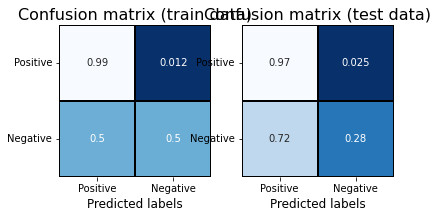

In [41]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_preds, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_preds, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

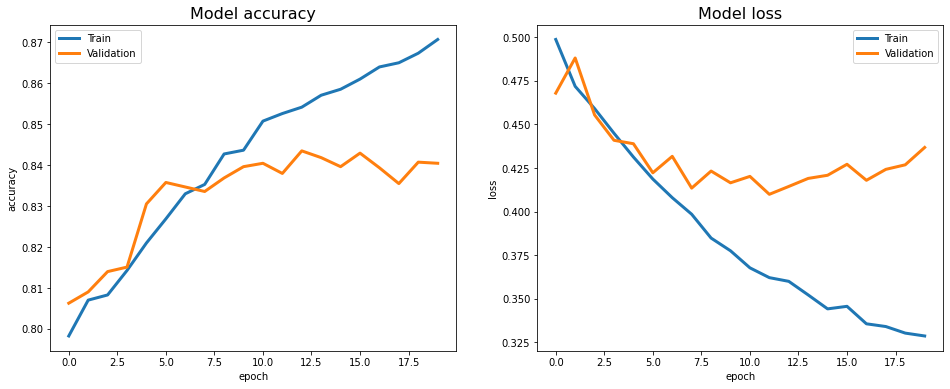

In [42]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [46]:
text = [spliter('안녕하세요')]
sample = pad_sequences(
    sequences=vectorize_data(text, vocab=ft_model.wv.vocab),
    maxlen=input_length,
    padding='post')
model.predict(sample)

Vectorize sentences... (done)


array([[0.2853213]], dtype=float32)